In [24]:
!pip install imbalanced-learn scikit-learn pandas numpy seaborn matplotlib joblib

In [25]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder, StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, RocCurveDisplay
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import warnings
warnings.filterwarnings('ignore')

In [26]:
# Load and display the dataset
df = pd.read_csv('Bank_Transaction_Fraud_Detection.csv')

# Display basic information about the dataset
print("📊 Dataset Overview:")
print("\nShape:", df.shape)
print("\nColumns:", df.columns.tolist())
print("\nSample Data:")
print(df.head())
print("\nData Types:")
print(df.dtypes) 
print("\nClass Distribution (Fraud vs Non-Fraud):")
print(df['Is_Fraud'].value_counts(normalize=True).mul(100).round(2).astype(str) + '%')

📊 Dataset Overview:

Shape: (200000, 24)

Columns: ['Customer_ID', 'Customer_Name', 'Gender', 'Age', 'State', 'City', 'Bank_Branch', 'Account_Type', 'Transaction_ID', 'Transaction_Date', 'Transaction_Time', 'Transaction_Amount', 'Merchant_ID', 'Transaction_Type', 'Merchant_Category', 'Account_Balance', 'Transaction_Device', 'Transaction_Location', 'Device_Type', 'Is_Fraud', 'Transaction_Currency', 'Customer_Contact', 'Transaction_Description', 'Customer_Email']

Sample Data:
                            Customer_ID        Customer_Name  Gender  Age  \
0  d5f6ec07-d69e-4f47-b9b4-7c58ff17c19e           Osha Tella    Male   60   
1  7c14ad51-781a-4db9-b7bd-67439c175262      Hredhaan Khosla  Female   51   
2  3a73a0e5-d4da-45aa-85f3-528413900a35       Ekani Nazareth    Male   20   
3  7902f4ef-9050-4a79-857d-9c2ea3181940  Yamini Ramachandran  Female   57   
4  3a4bba70-d9a9-4c5f-8b92-1735fd8c19e9         Kritika Rege  Female   43   

         State                City                Bank_Br

# Banking Transaction Fraud Analysis

Let's analyze key patterns in the banking transaction data:
1. Fraud distribution across different transaction types
2. Time patterns in fraudulent transactions
3. Amount patterns in fraud cases
4. Geographic distribution of fraud
5. Device and channel analysis

# Data Quality Analysis

Let's analyze the data quality to ensure our model is built on reliable data:
1. Check for missing values
2. Check for duplicates
3. Analyze value distributions
4. Identify outliers in transaction amounts

In [27]:
# Data Quality Checks

# 1. Missing Values Analysis
print("📊 Missing Values Analysis:")
missing_values = df.isnull().sum()
if missing_values.any():
    print("\nMissing values found:")
    print(missing_values[missing_values > 0])
else:
    print("✅ No missing values found")

# 2. Duplicate Check
duplicates = df.duplicated().sum()
print(f"\n🔍 Duplicate Records: {duplicates}")

# 3. Value Distributions
print("\n📈 Transaction Amount Distribution:")
print(df['Transaction_Amount'].describe())

# 4. Outlier Analysis for Transaction Amount
Q1 = df['Transaction_Amount'].quantile(0.25)
Q3 = df['Transaction_Amount'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers = df[(df['Transaction_Amount'] < lower_bound) | (df['Transaction_Amount'] > upper_bound)]
print(f"\n⚠️ Number of transaction amount outliers: {len(outliers)}")

# 5. Fraud Distribution by Key Features
print("\n🔍 Fraud Distribution by Key Features:")

# By Transaction Type
print("\nFraud % by Transaction Type:")
fraud_by_type = df.groupby('Transaction_Type')['Is_Fraud'].mean().mul(100).round(2)
print(fraud_by_type.sort_values(ascending=False))

📊 Missing Values Analysis:
✅ No missing values found

🔍 Duplicate Records: 0

📈 Transaction Amount Distribution:
count    200000.000000
mean      49538.015554
std       28551.874004
min          10.290000
25%       24851.345000
50%       49502.440000
75%       74314.625000
max       98999.980000
Name: Transaction_Amount, dtype: float64

⚠️ Number of transaction amount outliers: 0

🔍 Fraud Distribution by Key Features:

Fraud % by Transaction Type:
Transaction_Type
Transfer        5.19
Credit          5.10
Debit           5.08
Bill Payment    4.93
Withdrawal      4.93
Name: Is_Fraud, dtype: float64


In [28]:
df.shape

(200000, 24)

In [67]:
df.head(20)

,Gender,Age,State,City,Bank_Branch,Account_Type,Transaction_Date,Transaction_Time,Transaction_Amount,Transaction_Type,Account_Balance,Transaction_Device,Is_Fraud,Transaction_Currency
0,1,60,15,127,127,2,22,52151,32415.45,3,74557.27,17,0,0
1,0,51,18,100,100,0,10,55958,43622.60,0,74622.66,9,0,0
2,1,20,4,13,13,2,24,10257,63062.56,0,66817.99,0,0,0
3,0,57,28,22,22,0,18,40370,14000.72,2,58177.08,8,0,0
4,0,43,25,7,7,2,29,60052,18335.16,3,16108.56,16,0,0
5,1,54,10,2,2,1,24,22178,9711.15,3,61258.85,7,0,0
6,0,61,8,102,102,0,3,2909,94677.01,3,36313.61,11,0,0
7,1,32,0,109,109,0,15,13217,67704.28,2,16948.73,5,0,0
8,1,52,17,15,15,0,24,35134,72953.45,4,18138.71,0,0,0
9,0,32,6,55,55,0,1,14994,5689.02,1,65801.35,2,0,0


In [30]:
df.isnull().sum()

Customer_ID                0
Customer_Name              0
Gender                     0
Age                        0
State                      0
City                       0
Bank_Branch                0
Account_Type               0
Transaction_ID             0
Transaction_Date           0
Transaction_Time           0
Transaction_Amount         0
Merchant_ID                0
Transaction_Type           0
Merchant_Category          0
Account_Balance            0
Transaction_Device         0
Transaction_Location       0
Device_Type                0
Is_Fraud                   0
Transaction_Currency       0
Customer_Contact           0
Transaction_Description    0
Customer_Email             0
dtype: int64

In [31]:
# df_cleaned = df.drop(columns=  ['Customer_ID',
#     'Customer_Name',
#     'Transaction_ID',
#     'Customer_Contact',
#     'Customer_Email',
#     'Merchant_ID',
#     'Transaction_Description', 'Device_Type', 'Merchant_Category', 'Transaction_Location'], inplace=True)

# No need to drop columns, just assign df_cleaned
df.drop(columns=['Customer_ID',
    'Customer_Name',
    'Transaction_ID',
    'Customer_Contact',
    'Customer_Email',
    'Merchant_ID',
    'Transaction_Description', 
    'Device_Type', 
    'Merchant_Category', 
    'Transaction_Location'], inplace=True)
df_cleaned = df

In [32]:
df.shape

(200000, 14)

In [68]:
print(df_cleaned.head())

   Gender  Age  State  City  Bank_Branch  Account_Type  Transaction_Date  \
0       1   60     15   127          127             2                22   
1       0   51     18   100          100             0                10   
2       1   20      4    13           13             2                24   
3       0   57     28    22           22             0                18   
4       0   43     25     7            7             2                29   

   Transaction_Time  Transaction_Amount  Transaction_Type  Account_Balance  \
0             52151            32415.45                 3         74557.27   
1             55958            43622.60                 0         74622.66   
2             10257            63062.56                 0         66817.99   
3             40370            14000.72                 2         58177.08   
4             60052            18335.16                 3         16108.56   

   Transaction_Device  Is_Fraud  Transaction_Currency  
0                 

In [34]:
df_cleaned.shape

(200000, 14)

In [35]:
# # Feature Engineering based on domain knowledge
# print("🔧 Creating new features...")

# # 1. Time-based features
# print("\nProcessing time-based features...")
# df_cleaned['Transaction_Date'] = pd.to_datetime(df['Transaction_Date'], format='mixed', dayfirst=True)
# df_cleaned['Transaction_Time'] = pd.to_datetime(df['Transaction_Time'], format='%H:%M:%S').dt.time

# # Extract time components
# df_cleaned['Transaction_Hour'] = pd.to_datetime(df['Transaction_Time'], format='%H:%M:%S').dt.hour
# df_cleaned['Transaction_DayOfWeek'] = df_cleaned['Transaction_Date'].dt.dayofweek
# df_cleaned['Transaction_Day'] = df_cleaned['Transaction_Date'].dt.day
# df_cleaned['Transaction_Month'] = df_cleaned['Transaction_Date'].dt.month

# # Create time-based risk indicators
# df_cleaned['Is_Weekend'] = df_cleaned['Transaction_DayOfWeek'].isin([5, 6]).astype(int)
# df_cleaned['Is_Night'] = ((df_cleaned['Transaction_Hour'] >= 22) | 
#                          (df_cleaned['Transaction_Hour'] <= 5)).astype(int)
# df_cleaned['Is_Evening'] = ((df_cleaned['Transaction_Hour'] >= 18) & 
#                            (df_cleaned['Transaction_Hour'] <= 21)).astype(int)

# # 2. Amount-based features
# print("\nCreating amount-based features...")
# df_cleaned['Amount_to_Balance_Ratio'] = df_cleaned['Transaction_Amount'] / (df_cleaned['Account_Balance'] + 1)
# df_cleaned['Is_High_Amount'] = (df_cleaned['Transaction_Amount'] > 
#                                df_cleaned['Transaction_Amount'].quantile(0.95)).astype(int)


# # Scale numerical features
# print("\nScaling numerical features...")
# scaler = StandardScaler()
# num_cols = ['Age', 'Transaction_Amount', 'Account_Balance',
#             'Transaction_DayOfWeek', 'Transaction_Day',
#             'Transaction_Month', 'Transaction_Hour',
#             'Amount_to_Balance_Ratio']
# df_cleaned[num_cols] = scaler.fit_transform(df_cleaned[num_cols])

# # Save the scaler
# joblib.dump(scaler, 'scaler.pkl')
# print("\n✅ Feature engineering completed and scaler saved")



# Feature Engineering and Data Preprocessing

Let's create more meaningful features for fraud detection:
1. Time-based features
2. Transaction amount patterns
3. Customer behavior patterns

In [36]:
df_cleaned.shape

(200000, 14)

In [37]:
# Encode categorical columns
categorical_cols = df.select_dtypes(include='object').columns.tolist()
label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

In [38]:
df_cleaned.shape

(200000, 14)

In [39]:
# Separate features and target
# Drop Transaction_Date as it's not needed for SMOTE
X = df_cleaned.drop(columns=['Is_Fraud'])
y = df['Is_Fraud']

In [40]:
X.shape

(200000, 13)

In [41]:
# Split and oversample
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)


In [42]:
# Use SMOTE for class imbalance
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)


In [43]:
# 10. Preview the result
print("X_train shape:", X_train_resampled.shape)
print("y_train class distribution:\n", pd.Series(y_train_resampled).value_counts())

X_train shape: (303860, 13)
y_train class distribution:
 Is_Fraud
0    151930
1    151930
Name: count, dtype: int64


#**Model traning**
## Step-by-step

In [44]:
# 1. Import necessary libraries
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, RocCurveDisplay
import matplotlib.pyplot as plt
import seaborn as sns

In [45]:
# Train Random Forest with Cross-validation
rf_model = RandomForestClassifier(
    n_estimators=200,  # More trees for better performance
    max_depth=10,      # Control model complexity
    min_samples_split=5,
    min_samples_leaf=2,
    random_state=42,
    class_weight='balanced',  # Handle class imbalance
    n_jobs=-1  # Use all CPU cores
)

# Perform cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(rf_model, X_train_resampled, y_train_resampled, cv=cv, scoring='roc_auc')

print("📊 Cross-validation ROC AUC scores:", cv_scores)
print(f"📈 Mean ROC AUC: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")

# Train the final model
rf_model.fit(X_train_resampled, y_train_resampled)

# Get feature importance
feature_importance = pd.DataFrame({
    'feature': X_train_resampled.columns,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

print("\n🔍 Top 10 Most Important Features:")
print(feature_importance.head(10))

📊 Cross-validation ROC AUC scores: [0.82889118 0.82396108 0.82586208 0.82749777 0.8260799 ]
📈 Mean ROC AUC: 0.8265 (+/- 0.0033)

🔍 Top 10 Most Important Features:
               feature  importance
5         Account_Type    0.202078
9     Transaction_Type    0.170662
0               Gender    0.158262
11  Transaction_Device    0.113256
2                State    0.080152
4          Bank_Branch    0.065069
6     Transaction_Date    0.064913
3                 City    0.061552
1                  Age    0.055436
10     Account_Balance    0.009541


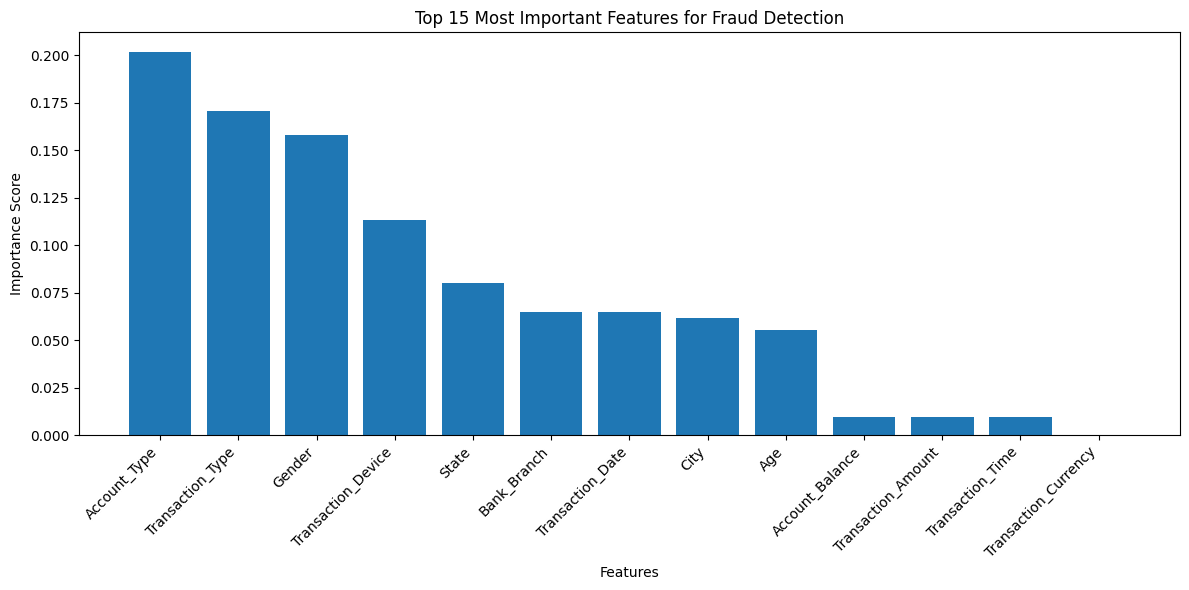


🔍 Feature Importance (Top 15):
                 feature  importance_percent
5           Account_Type              20.21%
9       Transaction_Type              17.07%
0                 Gender              15.83%
11    Transaction_Device              11.33%
2                  State               8.02%
4            Bank_Branch               6.51%
6       Transaction_Date               6.49%
3                   City               6.16%
1                    Age               5.54%
10       Account_Balance               0.95%
8     Transaction_Amount               0.95%
7       Transaction_Time               0.95%
12  Transaction_Currency               0.00%


In [46]:
# Visualize Feature Importance
plt.figure(figsize=(12, 6))
plt.bar(feature_importance['feature'][:15], feature_importance['importance'][:15])
plt.xticks(rotation=45, ha='right')
plt.title('Top 15 Most Important Features for Fraud Detection')
plt.xlabel('Features')
plt.ylabel('Importance Score')
plt.tight_layout()
plt.show()

# Print feature importance with percentages
print("\n🔍 Feature Importance (Top 15):")
top_features = feature_importance.head(15)
top_features['importance_percent'] = top_features['importance'] / top_features['importance'].sum() * 100
print(top_features[['feature', 'importance_percent']].to_string(float_format=lambda x: f"{x:.2f}%"))

In [47]:
# 3. Predict on test set
y_pred = rf_model.predict(X_test)
y_proba = rf_model.predict_proba(X_test)[:, 1]


# **Precision & Recall** :important for fraud detection
# **Confusion Matrix** :TP/FP/FN/TN

🔍 Classification Report:

              precision    recall  f1-score   support

           0       0.95      0.70      0.81     37982
           1       0.05      0.32      0.09      2018

    accuracy                           0.68     40000
   macro avg       0.50      0.51      0.45     40000
weighted avg       0.91      0.68      0.77     40000


📊 Confusion Matrix:


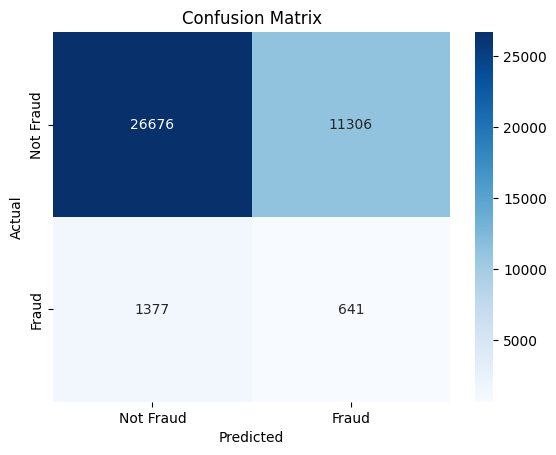

In [48]:
# 4. Evaluate performance
print("🔍 Classification Report:\n")
print(classification_report(y_test, y_pred))

print("\n📊 Confusion Matrix:")
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Fraud', 'Fraud'], yticklabels=['Not Fraud', 'Fraud'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# **ROC AUC Score** :how well the model separates fraud vs. non-fraud.

In [49]:
# 5. ROC AUC Score
roc_auc = roc_auc_score(y_test, y_proba)
print(f"🎯 ROC AUC Score: {roc_auc:.4f}")

🎯 ROC AUC Score: 0.5109


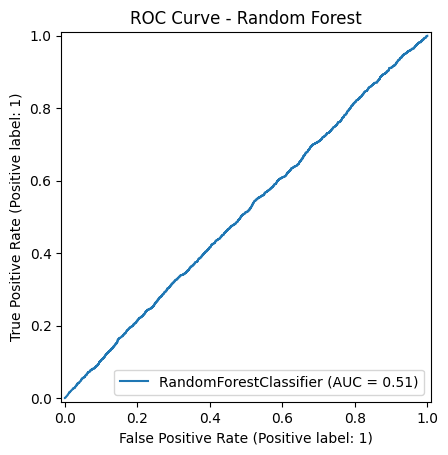

In [50]:

# 6. Plot ROC Curve
RocCurveDisplay.from_estimator(rf_model, X_test, y_test)
plt.title("ROC Curve - Random Forest")
plt.show()

In [51]:
df_cleaned['Transaction_Time'] = df['Transaction_Time']
print(df_cleaned['Transaction_Time'].sample(10).tolist())

[39040, 55546, 72628, 45845, 3215, 58254, 15988, 63123, 17371, 27292]


In [52]:
import joblib

In [70]:
# Save all components
print("🔄 Saving model components...")

# Save the model
joblib.dump(rf_model, 'model.pkl')
print("✅ Random Forest model saved as model.pkl")

# Save the encoders dictionary
joblib.dump(label_encoders, 'encoders.pkl')
print("✅ Label encoders saved as encoders.pkl")

# Note: scaler was already saved earlier

print("\n📝 Model Summary:")
print(f"Model Type: {type(rf_model).__name__}")
print(f"Number of features: {len(feature_importance)}")
print(f"Encoded categories available for: {list(label_encoders.keys())}")
print("\n⚠️ Important: Make sure these files are in the same directory as your Flask application!")
print("🔄 All components saved successfully!")

🔄 Saving model components...
✅ Random Forest model saved as model.pkl
✅ Label encoders saved as encoders.pkl

📝 Model Summary:
Model Type: RandomForestClassifier
Number of features: 13
Encoded categories available for: ['Gender', 'State', 'City', 'Bank_Branch', 'Account_Type', 'Transaction_Date', 'Transaction_Time', 'Transaction_Type', 'Transaction_Device', 'Transaction_Currency']

⚠️ Important: Make sure these files are in the same directory as your Flask application!
🔄 All components saved successfully!


In [56]:
# Test function for the trained fraud detection model
def test_fraud_model(sample_transaction):
    import joblib
    import pandas as pd

    # Load model and encoders
    model = joblib.load('model.pkl')
    encoders = joblib.load('encoders.pkl')

    # Use the feature names from training (X)
    feature_names = X.columns.tolist()

    # Ensure sample_transaction is a DataFrame with one row
    if isinstance(sample_transaction, dict):
        sample_transaction = pd.DataFrame([sample_transaction])
    elif isinstance(sample_transaction, pd.Series):
        sample_transaction = sample_transaction.to_frame().T

    # Fill missing columns with default values from X
    transaction = {}
    for col in feature_names:
        if col in sample_transaction.columns:
            transaction[col] = sample_transaction[col].iloc[0]
        else:
            # Use median for numeric, mode for categorical
            if X[col].dtype == 'object':
                transaction[col] = X[col].mode()[0]
            else:
                transaction[col] = X[col].median()

    # Create DataFrame
    transaction_df = pd.DataFrame([transaction])

    # Encode categorical columns
    for col in encoders:
        if col in transaction_df.columns:
            try:
                transaction_df[col] = encoders[col].transform(transaction_df[col].astype(str))
            except ValueError:
                transaction_df[col] = encoders[col].transform([encoders[col].classes_[0]])

    # Make prediction
    prediction = model.predict(transaction_df)[0]
    probability = model.predict_proba(transaction_df)[0][1]

    print("Prediction:", "Fraud" if prediction == 1 else "Not Fraud")
    print("Fraud Probability: {:.2%}".format(probability))

    return {"prediction": "Fraud" if prediction == 1 else "Not Fraud",
            "probability": probability}

# Example usage:
sample_transaction = pd.DataFrame({
    'Gender': ['Male'],
    'Age': [35],
    'State': ['Maharashtra'],
    'City': ['Mumbai'],
    'Bank_Branch': ['Mumbai Branch'],
    'Account_Type': ['Savings'],
    'Transaction_Amount': [50000],
    'Transaction_Type': ['UPI'],
    'Account_Balance': [100000],
    'Transaction_Currency': ['INR']
})

# Test the model
test_fraud_model(sample_transaction)

Prediction: Not Fraud
Fraud Probability: 28.26%


{'prediction': 'Not Fraud', 'probability': np.float64(0.2825697624879926)}

🗺️ Geographical Analysis of Fraud

Fraud Percentage by State:
State
28    5.62
16    5.58
27    5.39
32    5.33
33    5.32
17    5.31
21    5.30
29    5.29
30    5.25
14    5.25
7     5.21
24    5.18
22    5.17
13    5.10
8     5.10
18    5.08
19    5.06
20    5.03
23    5.02
3     4.99
5     4.97
12    4.94
9     4.92
6     4.92
31    4.92
2     4.87
1     4.82
0     4.75
25    4.72
10    4.71
4     4.66
26    4.62
11    4.59
15    4.53
Name: 1, dtype: float64

Top 10 Cities by Fraud Percentage:
City
45     6.72
11     6.49
60     6.48
46     6.36
102    6.35
24     6.26
42     6.24
3      6.14
131    6.10
69     5.98
Name: 1, dtype: float64


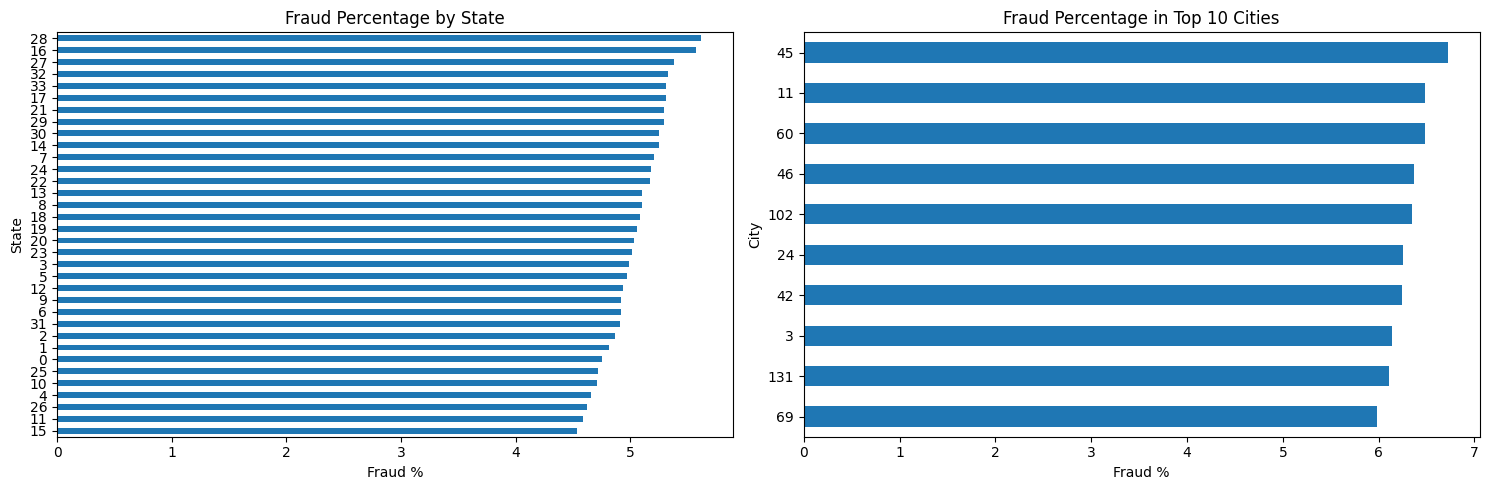


🚨 Geographical Risk Insights:

High-risk states (above average fraud rate):
State
7     5.21
8     5.10
13    5.10
14    5.25
16    5.58
17    5.31
18    5.08
19    5.06
21    5.30
22    5.17
24    5.18
27    5.39
28    5.62
29    5.29
30    5.25
32    5.33
33    5.32
Name: 1, dtype: float64

💰 Average Transaction Amount by Location Type:
Is_Fraud
0    49551.83
1    49277.93
Name: Transaction_Amount, dtype: float64


In [59]:
# Analyze geographical patterns in fraud
print("🗺️ Geographical Analysis of Fraud\n")

# State-wise analysis
state_fraud = pd.crosstab(df['State'], df['Is_Fraud'], normalize='index') * 100
print("Fraud Percentage by State:")
print(state_fraud.sort_values(by=1, ascending=False)[1].round(2))

# City-wise analysis
city_fraud = pd.crosstab(df['City'], df['Is_Fraud'], normalize='index') * 100
print("\nTop 10 Cities by Fraud Percentage:")
print(city_fraud.sort_values(by=1, ascending=False)[1].head(10).round(2))

# Visualize geographical patterns
plt.figure(figsize=(15, 5))

# State-wise fraud visualization
plt.subplot(1, 2, 1)
state_fraud[1].sort_values(ascending=True).plot(kind='barh')
plt.title('Fraud Percentage by State')
plt.xlabel('Fraud %')

# City-wise fraud visualization
plt.subplot(1, 2, 2)
city_fraud[1].sort_values(ascending=True).tail(10).plot(kind='barh')
plt.title('Fraud Percentage in Top 10 Cities')
plt.xlabel('Fraud %')

plt.tight_layout()
plt.show()

# Print risk insights
print("\n🚨 Geographical Risk Insights:")
high_risk_states = state_fraud[state_fraud[1] > state_fraud[1].mean()]
print("\nHigh-risk states (above average fraud rate):")
print(high_risk_states[1].round(2))

# Transaction amount patterns by location
print("\n💰 Average Transaction Amount by Location Type:")
location_amount = df.groupby('Is_Fraud')['Transaction_Amount'].mean()
print(location_amount.round(2))